# <html>
   
<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: auto; margin: 10px;">
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/University_of_Tehran_logo.svg/225px-University_of_Tehran_logo.svg.png" width=100px width=auto style="padding:10px; vertical-align: center;">

</div>
   
<div   style:"text-align: center; background-image: linear-gradient(to left, rgb(255, 255, 255), rgb( 219, 204, 245  ));width: 400px; height: 30px; ">
<h1 style="font-family: Georgia; color: black; text-align: center; ">Course: AI </h1>

</div>
    <div   style:"border: 3px solid green;text-align: center; ">
<h1 style="font-family: Georgia; color: black; text-align: center; ">Project5: CNN </h1>

</div>

   <div>    
<h1 style="font-family: Georgia; color: black; text-align: center; font-size:15px;">Mohammad Amanlou- sid:810100084 </h1>

</div>
   

</html>

# Artificial Intelligence Course - Fall 1402
## Computer Assignment #5 - CNN

## Problem Description
In this project, we plan to use a CNN neural network to create a model for classifying brain imaging images. In this model, we check the existence or non-existence or suspicion of brain tumor in each image and We put them in one of the related categories


# Part1.
## Making dataset

In [6]:
import os
import random
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch


class MMDDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}

        for idx, folder in enumerate(sorted(os.listdir(directory))):
            self.classes.append(folder)
            self.class_to_idx[folder] = idx
            folder_path = os.path.join(directory, folder)

            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, filename)
                    if file_path.endswith('.jpg'):
                        self.samples.append((file_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, class_index = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Debugging print statement:
        #print(f"__getitem__ returned: {type(image)}, {type(class_index)}")

        return image, class_index , self.classes[class_index]

to_tensor = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])




In [7]:
from torch.utils.data import random_split
dataset = MMDDataset(directory='/kaggle/input', transform=to_tensor)
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

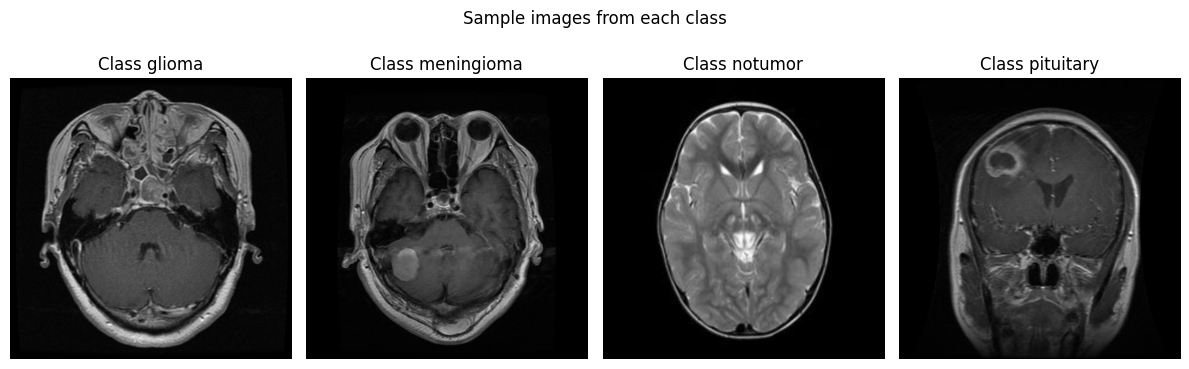

In [8]:
import matplotlib.pyplot as plt
import torch

pics = []
labels = []

num_classes = 4
for i in range(num_classes):
    found = False
    for image, label, label_name in dataset:
        if label == i:
            pics.append(image.squeeze(0))
            labels.append(label_name)
            found = True
            break
    if not found:
        print(f"No images found for class {i} in the training dataset.")

for index, tensor in enumerate(pics):
    pics[index] = transforms.ToPILImage()(tensor)

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Sample images from each class')

for i, (ax, img, lbl) in enumerate(zip(axes.flatten(), pics, labels)):
    ax.imshow(img)
    ax.set_title(f'Class {lbl}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Q1. Investigate the effect of normalization operation on the number of images and report its advantages and disadvantages.



Normalization is a preprocessing step commonly applied to image datasets before feeding them into a neural network for training or inference. The process involves changing the range of pixel intensity values to a standard scale. Here's a general outline of how normalization can impact datasets and its advantages and disadvantages.

#### Advantages of Normalization:

1. **Improves Convergence:** Normalization helps in stabilizing the learning process and speeds up convergence by ensuring that features are on a similar scale.
2. **Reduces Internal Covariate Shift:** By normalizing the inputs, we reduce the chances of internal covariate shift, which speeds up the training by allowing for higher learning rates.
3. **Helps to Avoid Saturation:** Neural networks (especially those with sigmoid activation functions) are at risk of 'saturation,' where extreme input values can 'kill' the gradients during backpropagation. Normalization helps to keep input values within the range where the neurons are most sensitive to input changes.
4. **Better Initial Weights:** During weight initialization, having features in a similar scale allows the optimizer to better traverse the loss landscape, potentially finding better minima.
5. **Eliminates Bias:** If certain features come in larger scales than others, they could dominate the optimization process. Normalization ensures this does not happen.

#### Disadvantages of Normalization:

1. **Loss of Some Information:** In cases where the contrast of the image is important for understanding the content, global normalization may unnecessarily standardize this aspect away.
2. **Complexity:** It adds additional processing steps in the data pipeline which sometimes can be complex if different images require different types of normalization.
3. **Parameter Dependence:** If the normalization step depends on certain parameters (e.g., mean and standard deviation of the training set), those need to be saved and correctly applied to data during inference as well, adding an extra step to the process.
4. **Potential Artifacts:** Some naive or aggressive normalization approaches might produce artifacts in the images that were not present prior to processing, which can affect model training.
5. **Requirement of Domain Knowledge:** There might be cases when domain-specific knowledge is required to decide what type of normalization is appropriate (e.g., local vs global normalization), otherwise it can negatively impact the model if chosen incorrectly.

Normalization does not change the number of images in the dataset; it only changes the values of the pixels within those images. The effect on the dataset is on the form and quality of the data for computational and learning efficiency, not on the size of the dataset.

However, it's crucial to apply the identical normalization parameters (for instance, the same mean and standard deviation used for training images) to the validation and test sets to keep conditions consistent across the whole data pipeline and avoid data leakage, thus ensuring that the trained model performs accurately with new data.






Here, after testing both methods with and without normalization, it was found that without normalization, more accuracy is achieved, because the missing data after convolution is naturally present. With normalization, the amount of missing data is It is getting more and more.


In [9]:
from torch.utils.data import random_split

def compute_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ , name in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.pow(2).sum(2).sum(0)
        total_images_count += batch_samples
    mean /= total_images_count
    std = (std / total_images_count - mean ** 2) ** 0.5
    return mean, std
mean, std = compute_mean_std(loader)
dataset_mean = list(mean.numpy())
dataset_std = list(std.numpy())

transform_with_normalization = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])


normalized_dataset = MMDDataset(directory='/kaggle/input', transform=transform_with_normalization)





### Q7. Explain about the batch size parameter and its effect in the training process

The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. When training a neural network, it’s not feasible or efficient to update the model’s weights with every sample (online learning) or after going through the entire dataset (because of the computational burden and memory constraints).

So, training often occurs using mini-batches.

#### Effects of Batch Size on Training Process:

1. **Memory Usage**:
   - **Smaller batches** use less memory, enabling you to train the model using limited resources.
   - **Larger batches** consume more memory, but you can leverage highly optimized matrix multiplication routines.

2. **Model Performance and Generalization**:
   - **Smaller batches** can introduce noise into the training process, which can lead to stronger generalization; however, they also make training less stable.
   - **Larger batches** provide a more stable error gradient for the optimizer leading perhaps to more stable convergence, but they might also converge to sharp minimizers and thus lead to poorer generalization.

3. **Computational Efficiency**:
   - **Smaller batches** can result in a more thorough exploration of the error landscape, while potentially taking longer to converge to a minimum.
   - **Larger batches** make each iteration take longer, but the model may require fewer iterations to converge.

4. **Convergence Speed**:
   - **Smaller batches** can sometimes escape local minima due to the noise in their gradient estimations, potentially leading to better overall solutions.
   - **Larger batches** tend to have a smoothing effect which can sometimes cause the optimizer to get stuck in a local minimum.

5. **Use of Parallelism**:
   - Larger batches are typically more amenable to parallelization, allowing for more efficient use of multi-core CPUs and GPUs which can lead to faster training times overall.

#### Choosing the Right Batch Size:

- It often requires experimentation as the optimal batch size can differ depending on the specific dataset and neural network architecture.
  
- As a rule of thumb, powers of 2 are often chosen (32, 64, 128, 256, ...) due to the way memory is structured and accessed in modern computing architectures, allowing for more efficient data retrieval.

#### Other Considerations:

- **Batch size vs. Learning rate**: Large batch sizes may require a different learning rate than small batch sizes. In some cases, larger batch sizes have been shown to benefit from learning rate scaling (linearly scaling up the learning rate with the batch size).

- **Training Stability**: Very large batch sizes may cause training instability, especially with inadequate learning rate scaling.

- In practice, many researchers and practitioners will balance the size of the batch with the available memory of the hardware used for training, along with empirical experimentation to find the size that provides a good compromise between training speed and model performance.

In [10]:
train_size = int(0.8 * len(normalized_dataset))
test_size = len(normalized_dataset) - train_size
train_dataset, test_dataset = random_split(normalized_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

{'glioma': 240, 'meningioma': 237, 'notumor': 327, 'pituitary': 244}
{'glioma': 60, 'meningioma': 69, 'notumor': 78, 'pituitary': 56}


/tmp/ipykernel_42/1791657697.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(train_class_counts.keys(), rotation=45)
/tmp/ipykernel_42/1791657697.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(test_class_counts.keys(), rotation=45)


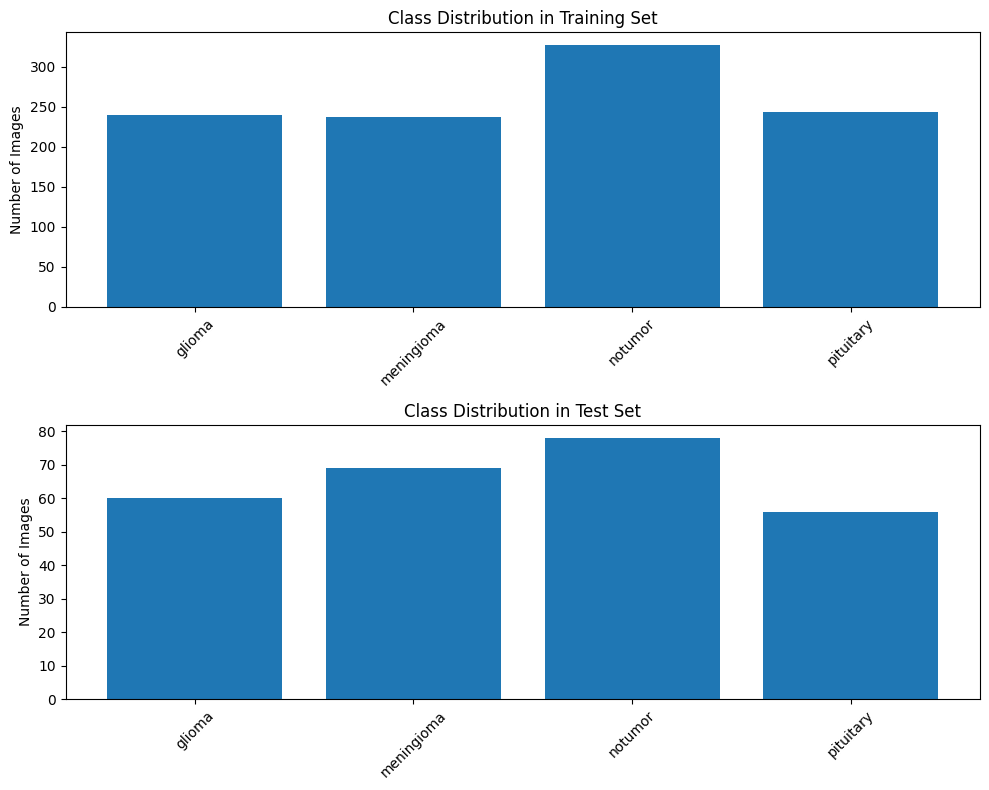

In [11]:
def get_class_distribution(dataset_obj, indices):
    count_dict = {cls: 0 for cls in dataset_obj.dataset.classes}

    for idx in indices:
        _, class_idx = dataset_obj.dataset.samples[idx]
        class_name = dataset_obj.dataset.classes[class_idx]
        count_dict[class_name] += 1

    return count_dict

train_class_counts = get_class_distribution(train_dataset, train_dataset.indices)
test_class_counts = get_class_distribution(test_dataset, test_dataset.indices)

print(train_class_counts)
print(test_class_counts)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))


ax[0].bar(train_class_counts.keys(), train_class_counts.values())
ax[0].set_title('Class Distribution in Training Set')
ax[0].set_ylabel('Number of Images')
ax[0].set_xticklabels(train_class_counts.keys(), rotation=45)


ax[1].bar(test_class_counts.keys(), test_class_counts.values())
ax[1].set_title('Class Distribution in Test Set')
ax[1].set_ylabel('Number of Images')
ax[1].set_xticklabels(test_class_counts.keys(), rotation=45)

plt.tight_layout()
plt.show()

In [12]:
classes = dataset.classes
print('Clasess Count: ', len(classes))
print('Classes: ', classes)

Clasess Count:  4
Classes:  ['glioma', 'meningioma', 'notumor', 'pituitary']


## Part2. Image classification using CNN network


### Q3. It is also necessary that the necessary explanations about how they work and also the reason for using them are given in the report. Required items in this section include kernel size and stride for different layers, padding used in different layers, number of convolutional layers, depth of convolutional network and

#### Convolutional Layers:
Convolutional layers are the core building blocks of a CNN. They apply a set of learnable filters to the input image to create feature maps. These filters detect spatial hierarchies of features—from edges in the early layers to complex patterns in the deeper layers.

#### Kernel Size:
The kernel (or filter) size determines the width and height of the filter window that slides over the input image to produce a single pixel in the feature map. For example, a 3x3 filter looks at a 3-pixel by 3-pixel region of the image.

- **Why use different kernel sizes?**
    - Smaller kernels (like 3x3 or 5x5) are good for capturing more detailed features and are computationally more efficient.
    - Larger kernels (like 7x7 or beyond) capture broader features of the image but significantly reduce the spatial dimensions and may miss finer details.

#### Stride:
Stride dictates the number of pixels by which the filter window moves across the input image. A stride of 1 moves the filter one pixel at a time, resulting in dense feature mapping. A larger stride reduces the spatial dimensions of the output feature map, leading to less computation and memory usage but possibly losing some fine-grained patterns.

#### Padding:
Padding involves adding layers of zeros around the border of the input image to allow the convolution operation to be applied to the bordering elements of the input image.
- **Why use padding?**
    - To control the spatial size of the output volumes, often to maintain the same input and output dimensions.
    - To enable the network to learn features from the corners and edges of the images.

#### Number of Convolutional Layers:
This refers to the depth of the network, the number of convolutional layers stacked together. Increasing depth can enhance the network's ability to represent complex features.

- **Why adjust the number of layers?**
    - More layers can help the network learn a hierarchical representation of the data.
    - Too many layers might lead to overfitting and make the network harder to train, especially without sufficient data.
    - As you go deeper, the spatial size tends to decrease whereas the depth (number of filters) increases, moving from raw pixels to abstract concepts.

#### Depth of Convolutional Network:
The term "depth" can refer to two things: the number of layers or the number of channels (feature maps) in each layer.

- **Why increase depth?**
    - Deeper networks can potentially learn more complex features and achieve better performance.
    - However, they can be challenging to train due to issues like vanishing gradients, although techniques such as skip connections (e.g., ResNet) and batch normalization help overcome these challenges.
    - Deeper channels (more filters) in a layer allow a network to learn a wider variety of features from the same level of complexity in the data.

#### Considerations:
The choice of kernel size, stride, and padding also interacts with the image size and the number of convolutional layers to determine the overall architecture of the network. Properly sizing and structuring the network is as much an art as a science and often involves empirical testing and tuning.

When designing a CNN architecture, you often start with industry standards or proven network architectures (such as VGG, ResNet, Inception, etc.) and then customize and adapt based on your specific problem and dataset size. The goal is to balance performance (in terms of both prediction quality and computational efficiency) with the avoidance of overfitting, under the constraints of what's meaningful for your data and the problem at hand. Hyperparameter tuning and network architecture searching are extensive fields that seek to automate this part of model development.

In [13]:

from torch import nn

class ModelBrain(nn.Module):
    def __init__(self, num_channels: int, hidden_units: int, output_shape: int):
        super(ModelBrain, self).__init__()
        # Define the convolution part with added layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=8, padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self._to_linear = 16  *124*124

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units // 4),
            nn.LeakyReLU(),
            nn.Linear(hidden_units // 4, output_shape)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, self._to_linear)
        return self.fc_layer(x)


num_channels = 3
hidden_units = 2048
output_shape = 4

model = ModelBrain(num_channels=num_channels, hidden_units=hidden_units, output_shape=output_shape)

In [35]:
import torch
from torch import nn

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(True),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True),
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=4):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        # GoogLeNet has 9 inception modules in the middle, with various configurations
        # For simplicity, I am including only a few of them
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        # Note: Auxiliary classifiers are typically inserted here, but are omitted for brevity

        self.maxpool4 = nn.MaxPool2d(2, stride=2, padding=1)

        # The number of inception modules and their arrangements can be modified
        # depending on the input size and the complexity of the dataset
        # ...

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(512, 128)  
        self.fc2 = nn.Linear(128, num_classes)  

    def forward(self, x):
        # Add print statements to debug the size of output at each stage
        x = self.conv1(x)
        #print("After conv1:", x.shape)
        x = self.maxpool1(x)
        #print("After maxpool1:", x.shape)
        x = self.conv2(x)
        #print("After conv2:", x.shape)
        x = self.conv3(x)
        #print("After conv3:", x.shape)
        x = self.maxpool2(x)
        #print("After maxpool2:", x.shape)
        x = self.inception3a(x)
        #print("After inception3a:", x.shape)
        x = self.inception3b(x)
        #print("After inception3b:", x.shape)
        x = self.maxpool3(x)
        #print("After maxpool3:", x.shape)
        x = self.inception4a(x)
        # More inception modules can be inserted here
        #print("After last inception module:", x.shape)
        x = self.maxpool4(x)
        x = self.avgpool(x)
        #print("After avgpool:", x.shape)
        x = torch.flatten(x, 1)
        #print("After flatten:", x.shape)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.fc2(x)
        return x

Gmodel = GoogLeNet(num_classes=4)




#### nn.Conv2d Parameters:
1. `num_channels`: Number of input channels for the first convolutional layer. For RGB images, this is 3.
2. `out_channels`: Number of filters or kernels the convolutional layer will learn from the input. Here, it's set to 16, meaning there will be 16 feature maps after this layer.
3. `kernel_size`: Size of the convolution filter. A `kernel_size` of 10 means a 10x10 filter.
4. `padding`: Zero-padding added to the borders of the input matrix. Padding of 1 adds a single layer of 0s around the image, which enables the kernel to process the edges of the input image.

#### nn.ReLU:
It's an activation function that introduces non-linearity into the model, allowing it to learn more complex patterns. The ReLU function is defined as `f(x) = max(0, x)`.

#### nn.AvgPool2d:
1. `kernel_size`: The size of the window over which the average value is taken. Here, it's 2x2, which means it reduces the height and width of the feature maps by a factor of 2.
2. `stride`: Controls how much the pooling window moves for each pooling step. In this case, it also is 2, meaning no overlap between pooled regions.

#### Fully connected layers - nn.Linear:
1. `self._to_linear`: This is not a standard PyTorch parameter, rather it's a user-defined value computed based on the output shape of the `conv_layer`. It's critical to update this calculation because the convolution and pooling operations will alter the size of the output feature map. For a convolution with padding 1 and kernel size 10, you actually need to re-calculate the output dimensions.
2. `hidden_units`: The number of neurons in the hidden layer of the fully connected part. It's set to 256 and is a hyperparameter that can be tuned.
3. `output_shape`: The size of the output layer, which corresponds to the number of classes in a classification task. Here, it's set to 4.

#### Forward pass:
The `forward` method defines how your data moves through the network. The input `x` goes through the convolutional layers, then it's flattened to match the dimensionality expected by the fully connected layers, and finally, it is passed through these linear layers to produce the output.

#### Effects of changing parameters and hyperparameters:

1. Increasing `num_channels`: This is typically based on the input data (e.g., RGB images have 3 channels, grayscale has 1). Changing it arbitrarily won't make sense.
2. More `out_channels`: More filters capture additional features but increase computational cost and model complexity.
3. Larger `kernel_size`: Larger kernels capture more context but reduce feature map size more drastically.
4. Increasing `padding`: Helpful to preserve feature map size, can lead to better edge feature extraction; too much padding can dilute feature intensity.
5. More `hidden_units`: A higher number allows the network to learn more complex patterns but may lead to overfitting and increased computational costs.
6. Changing `output_shape`: It's based on the number of output classes you have; changing it otherwise will mismatch the problem's requirements.

Additionally:

- **Number of Layers**: Adding more layers can help the network learn deeper, more abstract patterns. However, it can also lead to overfitting and increased computational demands. It's a delicate balance and must be informed by cross-validation performance.
  
- **Batch Size**: Larger batch sizes result in more stable gradient estimates during training but can cause memory issues. Smaller batch sizes offer more updates per epoch but can be noisy.

- **Learning Rate**: Controls the size of the update steps during optimization. A high learning rate might converge quickly but can overshoot minima, while a low learning rate might get stuck in local minima or take a long time to converge.

Remember that adjusting these parameters can significantly impact how well your model learns from the training data, how quickly it trains, and how well it generalizes to unseen data. It's often necessary to experiment and use techniques like cross-validation to determine optimal values for your specific task and dataset.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
model = model.to(device)

### Q4. It is necessary to mention the different cost functions, how they work, the application of each of them and also the reason for choosing your final cost function.

Cost functions, also known as loss functions, are a crucial component in training neural networks. They measure the difference between the network's predicted output and the actual target values. This difference or "loss" is used to adjust the model parameters during training with the goal of minimizing the loss. Below are several common cost functions, how they work, their applications, and the rationale behind selecting a particular cost function.

#### Mean Squared Error (MSE) Loss:
- **How it Works**: It calculates the average squared difference between the predicted values and the actual values.
- **Applications**: MSE is widely used for regression problems where you need to predict continuous outputs.
- **Why Choose It**: It penalizes larger errors more than smaller ones due to squaring the error terms, which can be desirable in some regression problems.

#### Cross-Entropy Loss (also known as Log Loss):
- **How it Works**: It measures the performance of a classification model whose output is a probability between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.
- **Applications**: It’s commonly used in classification tasks, including multi-class classification and binary classification.
- **Why Choose It**: It’s well-suited for probability distributions and provides a high penalty for predictions that are confidently incorrect, which drives the model towards confident and correct predictions.

#### Binary Cross-Entropy Loss:
- **How it Works**: A special case of cross-entropy loss for binary classification problems. It calculates the loss for each label in the dataset.
- **Applications**: Used when there are only two label classes (e.g. spam vs not-spam).
- **Why Choose It**: It’s effective in scenarios where you need the probabilities of binary outcomes.

#### Negative Log-Likelihood Loss:
- **How it Works**: This loss is used when the model outputs a log-probability. It is minimized when the model's predicted probability of the correct class is maximized.
- **Applications**: Commonly used with models ending with a softmax activation function for classification tasks.
- **Why Choose It**: Functions well with probabilities when you have a multinomial distribution and can provide more stable convergence than direct probability outputs.

#### Hinge Loss:
- **How it Works**: Designed for binary classification tasks. It is used for "maximum-margin" classification, notably for support vector machines (SVMs).
- **Applications**: Often used in training classifiers like SVMs, and sometimes in neural networks for binary classification.
- **Why Choose It**: It encourages the model to classify correctly and with confidence by penalizing predictions that are not only wrong but also those that are not sufficiently far from the classification boundary.

#### Categorical Cross-Entropy Loss:
- **How it Works**: It is the extension of binary cross-entropy loss to multi-class classification tasks.
- **Applications**: Used when there are two or more label classes. Each label is one-hot encoded.
- **Why Choose It**: Effective for multi-class classification problems, especially when each example belongs to a single category.

#### Kullback-Leibler (KL) Divergence Loss:
- **How it Works**: Measures how one probability distribution diverges from a second, reference probability distribution.
- **Applications**: Commonly used in variational autoencoders (VAEs) and in situations where you want to match to a particular distribution.
- **Why Choose It**: Useful for problems where you have a known target distribution you want to match.

#### Choosing a Cost Function:
The choice of a cost function depends on the specific characteristics of the problem:

- In **regression tasks**, you would typically use MSE or Mean Absolute Error (MAE) if you're concerned about outlier robustness.
- For **classification**, cross-entropy loss functions are standard because they work well with probability distributions, which is what classification models output.
- If you are working with models that need to be confident and accurate at the same time (like in certain classification tasks or SVMs), hinge loss might be appropriate.
- Specialized loss functions like KL divergence are used for specific objectives, such as when trying to approximate complex probability distributions.

When constructing and training a CNN, the final cost function should align with your model's architecture and the specific type of problem you're trying to solve. It should effectively drive the training process toward an accurately predictive model while also maintaining computational stability and efficiency.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Q5. Learn about the Adam optimizer and briefly describe how it works and how it differs from SDG. Also, if you use any optimization for the model, briefly describe your reason

The Adam (Adaptive Moment Estimation) optimizer is a popular algorithm for training neural networks. It combines ideas from two other optimizations algorithms: RMSprop (Root Mean Square Propagation) and SGD (Stochastic Gradient Descent) with momentum.

#### How Adam Works:
Adam maintains two running averages for each weight in the neural network:

1. **The first moment** – This is essentially the running average of the gradients, similar to the momentum in SGD, which helps to accelerate the training in the right direction.
2. **The second moment** – This is the running average of the gradient squared, similar to RMSprop, and it adapts the learning rate for each weight based on the magnitudes of its gradients.

The running averages are initialized as vectors of 0's at the start. They're updated at each iteration during training. The moment estimates are then bias-corrected to counteract their initialization at the origin. The corrected moments are used to update the weights, combining the benefits of momentum and adaptive learning rates.

#### Adam vs. SGD:
While the standard SGD updates weights by taking a step proportional only to the average of the recent gradients (optionally, with a momentum term), Adam modifies this process by scaling the step size for each weight based on the historical squared gradients (the variance).

Main differences include:

1. **Adaptive Learning Rates**: SGD maintains a single learning rate (step size) for all weight updates which doesn't change. Adam computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
2. **Momentum**: While momentum can be used alongside SGD, Adam has it incorporated by design. In Adam, the accumulation of past gradients furnishes a momentum effect, smoothing the optimization process.
3. **Bias Correction**: Because Adam calculates adaptive learning rates based on running averages that start out as zero, it includes a bias correction mechanism to compensate for this early underestimation.

#### Choosing Adam for Optimization:
Adam is often chosen as the default optimizer for many deep learning tasks because:

- It requires little tuning of hyperparameters (often the default values of alpha=0.001, beta1=0.9, beta2=0.999, and epsilon=10^-7 work well).
- It combines the advantages of other optimization techniques, making it suitable for a wide range of problems and data modalities.
- It's less sensitive to the scale of the gradients, which is a benefit in models and problems where the gradient magnitudes vary significantly.

Adam is especially popular in scenarios where you need quick and efficient convergence, especially when working with large datasets and/or high parameter models such as deep learning architectures. However, there are cases where SGD might converge to a better (or more stable) solution given enough time and careful tuning of the learning rate schedule. Some recent works have suggested that sometimes models trained with SGD generalize better than those trained with Adam, but this is not a one-size-fits-all situation.

Ultimately, the choice of optimizer is another hyperparameter to tune, and considering computational efficiency, ease of use, and empirical performance on the validation set should inform the decision.

In [16]:
device

'cuda'

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/9
----------
Train Loss: 1.4369, Train Accuracy: 31.30%
Test Loss: 1.2452, Test Accuracy: 29.66%
Epoch 2/9
----------
Train Loss: 1.0750, Train Accuracy: 57.63%
Test Loss: 0.8404, Test Accuracy: 65.40%
Epoch 3/9
----------
Train Loss: 0.6379, Train Accuracy: 75.29%
Test Loss: 0.6056, Test Accuracy: 73.76%
Epoch 4/9
----------
Train Loss: 0.5815, Train Accuracy: 79.48%
Test Loss: 0.5880, Test Accuracy: 79.47%
Epoch 5/9
----------
Train Loss: 0.3546, Train Accuracy: 87.79%
Test Loss: 0.5278, Test Accuracy: 80.99%
Epoch 6/9
----------
Train Loss: 0.5919, Train Accuracy: 88.74%
Test Loss: 1.0362, Test Accuracy: 63.50%
Epoch 7/9
----------
Train Loss: 0.3657, Train Accuracy: 87.69%
Test Loss: 0.6166, Test Accuracy: 82.89%
Epoch 8/9
----------
Train Loss: 0.2226, Train Accuracy: 93.61%
Test Loss: 0.7942, Test Accuracy: 81.75%
Epoch 9/9
----------
Train Loss: 0.1143, Train Accuracy: 96.18%
Test Loss: 0.8893, Test Accuracy: 85.55%


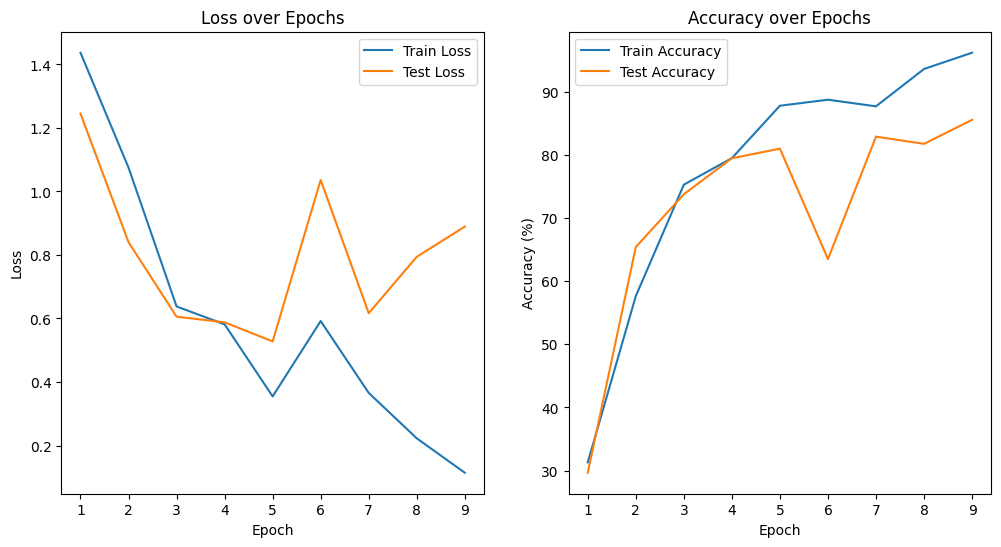

In [17]:
import matplotlib.pyplot as plt

epochs = 9
from tqdm.notebook import tqdm

# Lists to keep track of progress
epoch_count = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    test_loss = 0.0
    correct_train = 0
    correct_test = 0
    total_train = 0
    total_test = 0

    print("Epoch {}/{}".format(epoch+1, epochs))
    print("-"*10)

    model.train()  # Set model to training mode
    for images, labels, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear gradients

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)


        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()


    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)

    train_accuracy = correct_train / total_train * 100
    test_accuracy = correct_test / total_test * 100

    print("Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(train_loss, train_accuracy))
    print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy))


    epoch_count.append(epoch+1)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_count, train_losses, label='Train Loss')
plt.plot(epoch_count, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epoch_count, train_accuracies, label='Train Accuracy')
plt.plot(epoch_count, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(real_labels , pred_labels):
    classes = train_dataset.dataset.classes
    cm = confusion_matrix(real_labels, pred_labels)
    # Create a heatmap
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap = "RdYlGn", cbar=False,xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    return cm

In [25]:
import matplotlib.patches as mpatches
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    predicts = []
    reality = []
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels , name in data_loader:

            # Determine prediction of model on dev set
            data_inputs= data_inputs.to(device)#, data_labels.to(device) , name.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=0)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = ([torch.argmax(i) for i in preds]) # Binarize predictions to 0 and 1
            pred_labels = torch.tensor([i.item() for i in pred_labels])
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            for p , r in zip(pred_labels,data_labels):
                predicts.append(p)
                reality.append(r)
    cm = make_confusion_matrix(reality , predicts)

    acc = true_preds / num_preds
    test_loss = 0.0
    with torch.no_grad():
        for images, labels , name in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * images.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    print("Test Loss is:{:.4f}".format( test_loss))
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    return cm

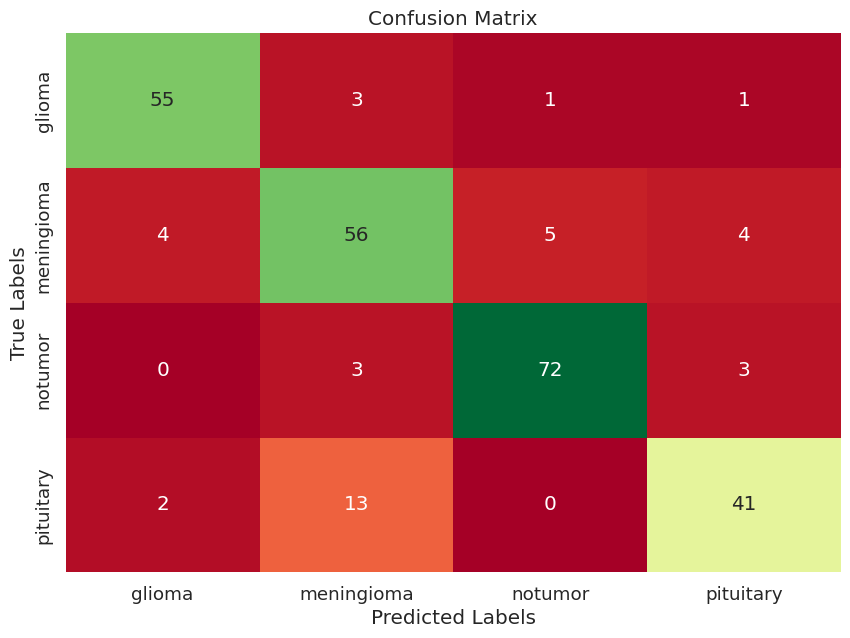

Test Loss is:0.8893
Accuracy of the model: 85.17%


In [26]:
cm = eval_model(model ,test_loader )

In [32]:
def scoring(cm):
    classes = train_dataset.dataset.classes
    col_sum = [cm[0][i] + cm[1][i]  for i in range(4)]
    precision = [cm[i][i]/sum(cm[i]) for i in range(0,4)]
    recalls = [cm[i][i] / col_sum[i] for i in range(4)]
    F1_score = [(2*precision[i]*recalls[i])/ (precision[i] + recalls[i]) for i in range(4)]
    accuracy = sum(cm[i][i] for i in range(4))/sum(sum(cm))
    plt.clf()
    plt.figure(figsize=(5, 3))
    plt.scatter(classes, precision)
    plt.scatter(classes, recalls)
    plt.scatter(classes, F1_score)
    plt.grid()
    plt.xlabel("class")
    plt.ylabel("metric")
    blue_patch = mpatches.Patch(color='blue',label='precision')
    orange_patch = mpatches.Patch(color='orange',label='F1_score')
    green_patch = mpatches.Patch(color='green',label='recalls')
    plt.legend(handles=[blue_patch,orange_patch,green_patch])
    
    # Adding the exact values on the plot
    for i , c in enumerate(classes):
        plt.text(c, precision[i], f'{precision[i]:.2f}', ha='center', va='bottom')
        plt.text(c, recalls[i], f'{recalls[i]:.2f}', ha='center', va='bottom')
        plt.text(c, F1_score[i], f'{F1_score[i]:.2f}', ha='center', va='bottom')
    plt.xticks([0, 1])
    plt.show()


    print(f"Precision: {precision[0]:.2f}")
    print(f"Recall: {recalls[0]:.2f}")
    print(f"F1 Score: {F1_score[0]:.2f}")
    print()

    weighted_average = sum(F1_score)/4
    micro_average = (sum(cm[i][i] for i in range(4)) / sum(sum(cm))) + (sum(cm[i][i] for i in range(4)) / sum(sum(cm))) / 4
    macro_average = sum(F1_score)/4
    print("micro average: " + str(micro_average))
    print("weighted_average: " + str(weighted_average))
    print("macro average: " + str(macro_average))
    print("accuract: " + str(accuracy))

<Figure size 640x480 with 0 Axes>

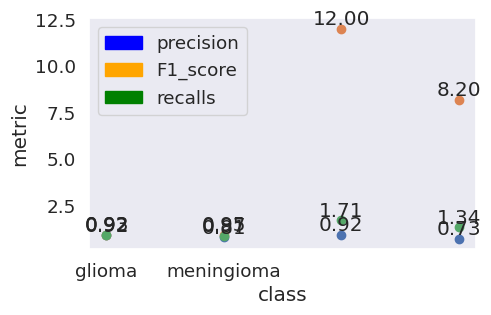

Precision: 0.92
Recall: 0.93
F1 Score: 0.92

micro average: 1.064638783269962
weighted_average: 1.21447943931671
macro average: 1.21447943931671
accuract: 0.8517110266159695


In [33]:
scoring(cm)

## Part3. Regularization.


### Q8. Two very common methods to do this are using Dropout and Batch Normalization. First, investigate and report on the performance of each of these two methods.




Dropout and Batch Normalization are important techniques in training deep neural networks. They address different issues and can be applied independently or together. Below is an overview of each method's purpose and performance impacts when used in neural networks.

#### Dropout

Dropout is a regularization technique that prevents overfitting by randomly dropping units (along with their connections) from the neural network during training. This means that each time an input is passed through the network, a subset of neurons does not contribute to the forward pass and the subsequent backpropagation. As a result, the model becomes less sensitive to the specific weights of neurons and more robust to unseen data.

**Performance Impact**:
- **Overfitting Reduction**: Networks tend to generalize better and thus perform better on unseen data.
- **Network Robustness**: It encourages the network to develop redundant pathways, increasing robustness.
- **Training Time**: Can increase training time since it often requires more epochs for convergence.
- **Inference Time**: No impact since dropout is only applied during training, not during inference.

#### Batch Normalization

Batch Normalization (BN) is a technique that stabilizes and speeds up the learning process by normalizing the inputs of each layer. By adjusting and scaling the activations, it ensures that the distribution of the inputs to a layer doesn't change too much, which can prevent issues like the vanishing or exploding gradient problems.

**Performance Impact**:
- **Training Speed**: Typically makes the network faster to train. It allows for the use of higher learning rates and reduces the sensitivity to initialization.
- **Convergence**: Networks often converge quicker with batch normalization.
- **Model Performance**: Can improve model performance, as it has a slight regularization effect.
- **Inference Time**: Can slightly increase inference time as there are extra computations for normalization; however, this can be mitigated by folding BN into the preceding layers during optimization.

#### Combining Dropout and Batch Normalization
While both methods have their pros and cons, there's often a benefit in combining them, but the order of operations matters. Generally, BN is applied right after convolutional layers (and before non-linearities), while dropout is placed after the activation functions. There has been some debate and research into the proper ordering of these layers, and it may depend on the specific architecture and task.

#### Experimental Validation
The ultimate performance metrics for these methods come from empirical experimentation:
- **A/B Testing**: Run experiments with different combinations of dropout and batch normalization to see which yields the best results on your validation data.
- **Monitor Training/Validation Loss**: Track the training and validation loss over epochs; batch normalization typically smooths out training curves, whereas dropout can make them noisier but usually increases validation performance.
- **Early Stopping**: Both techniques can change the ideal stopping point for training, so using an early-stopping criterion based on validation loss can be beneficial.

In summary, dropout is primarily a regularization method to combat overfitting, and batch normalization helps in normalizing the input distribution to each layer, thus speeding up the training and potentially allowing for better model performance. The effects on performance should be considered in the context of the specific architecture and problem being addressed.

In [44]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [48]:
from torch import nn

class ModelBrain(nn.Module):
    def __init__(self, num_channels: int, hidden_units: int, output_shape: int):
        super(ModelBrain, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=8, padding=1),
            nn.BatchNorm2d(16),  
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),  
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self._to_linear = 16 * 124 * 124
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, hidden_units),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),  
            nn.Linear(hidden_units, hidden_units // 4),
            nn.LeakyReLU(),
            nn.Linear(hidden_units // 4, output_shape)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        if (self._to_linear == 16 * 124 * 124):
            self._to_linear = x[0].nelement() 
        x = x.view(-1, self._to_linear)
        return self.fc_layer(x)

num_channels = 3
hidden_units = 2048
output_shape = 4

model = ModelBrain(num_channels=num_channels, hidden_units=hidden_units, output_shape=output_shape)

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/9
----------
Train Loss: 4.1559, Train Accuracy: 48.57%
Test Loss: 1.0638, Test Accuracy: 56.65%
Epoch 2/9
----------
Train Loss: 1.3740, Train Accuracy: 54.01%
Test Loss: 0.8248, Test Accuracy: 64.26%
Epoch 3/9
----------
Train Loss: 1.2317, Train Accuracy: 62.31%
Test Loss: 1.8175, Test Accuracy: 60.84%
Epoch 4/9
----------
Train Loss: 0.8846, Train Accuracy: 71.28%
Test Loss: 1.6185, Test Accuracy: 54.75%
Epoch 5/9
----------
Train Loss: 1.1297, Train Accuracy: 65.94%
Test Loss: 1.0152, Test Accuracy: 55.51%
Epoch 6/9
----------
Train Loss: 0.7998, Train Accuracy: 75.29%
Test Loss: 0.7170, Test Accuracy: 70.34%
Epoch 7/9
----------
Train Loss: 0.6232, Train Accuracy: 79.39%
Test Loss: 0.5853, Test Accuracy: 77.19%
Epoch 8/9
----------
Train Loss: 0.4813, Train Accuracy: 85.31%
Test Loss: 0.5617, Test Accuracy: 79.47%
Epoch 9/9
----------
Train Loss: 0.3414, Train Accuracy: 89.98%
Test Loss: 0.5957, Test Accuracy: 82.13%


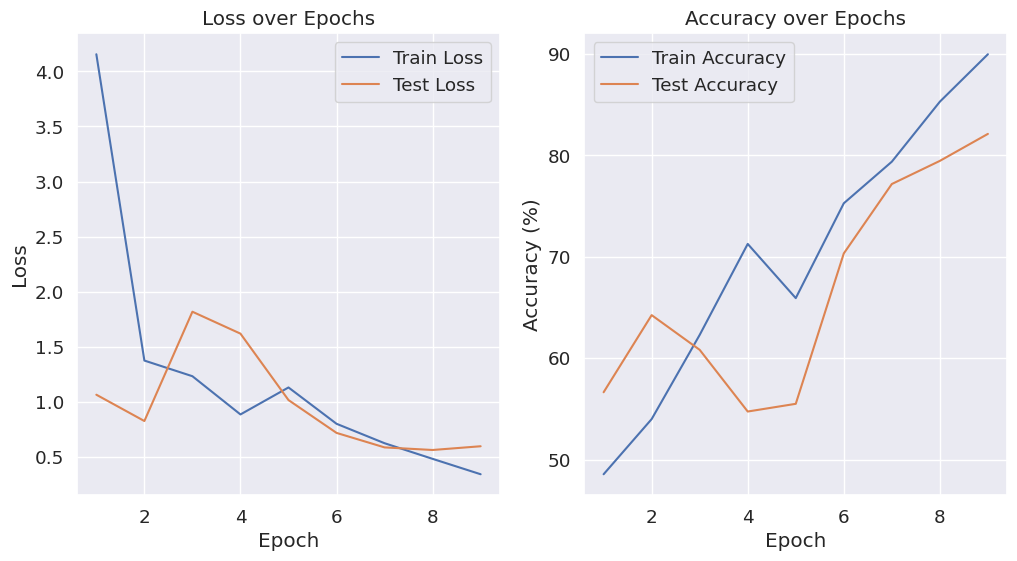

In [50]:
import matplotlib.pyplot as plt

epochs = 9
from tqdm.notebook import tqdm

# Lists to keep track of progress
epoch_count = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    test_loss = 0.0
    correct_train = 0
    correct_test = 0
    total_train = 0
    total_test = 0

    print("Epoch {}/{}".format(epoch+1, epochs))
    print("-"*10)

    model.train()  # Set model to training mode
    for images, labels, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear gradients

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)


        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()


    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)

    train_accuracy = correct_train / total_train * 100
    test_accuracy = correct_test / total_test * 100

    print("Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(train_loss, train_accuracy))
    print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy))


    epoch_count.append(epoch+1)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_count, train_losses, label='Train Loss')
plt.plot(epoch_count, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epoch_count, train_accuracies, label='Train Accuracy')
plt.plot(epoch_count, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

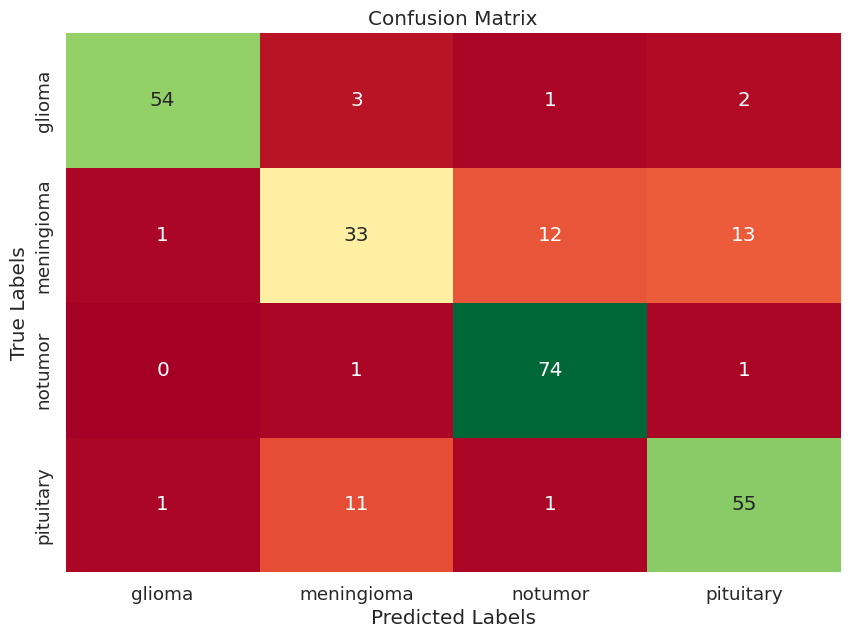

Test Loss is:0.5957
Accuracy of the model: 82.13%


In [51]:
cm = eval_model(model ,test_loader )

<Figure size 640x480 with 0 Axes>

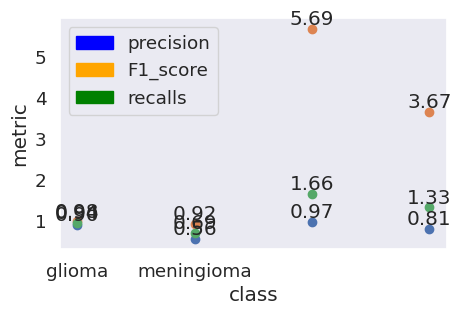

Precision: 0.90
Recall: 0.98
F1 Score: 0.94

micro average: 1.0266159695817492
weighted_average: 1.1555224575054388
macro average: 1.1555224575054388
accuract: 0.8212927756653993


In [52]:
scoring(cm)

As it can be seen, when we use regularization methods, the model is overfit much later. These methods help to reduce the very large coefficients in the model and the extremely high complexity is less likely. After doing this method, you will get the following results, which are a little better than the results without regularization


The important problem in these methods is that the model probably converges later
